In [1]:
import pprint
import os
import copy
import glob
import math

import numpy as np
import scipy.spatial.transform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from PIL import Image
import torch
import torchvision.utils
%matplotlib inline

# from im2scene import config
import im2scene
import im2scene.config
import im2scene.checkpoints
import im2scene.giraffe.models
import im2scene.giraffe.models.decoder
import im2scene.discriminator.conv 
import im2scene.giraffe.models.bounding_box_generator
import im2scene.giraffe.models.neural_renderer
import im2scene.giraffe.models.generator
import im2scene.giraffe.rendering
from im2scene.common import interpolate_sphere

pp = pprint.PrettyPrinter(indent=0)

In [2]:
def BB3D_about_origin(x, y, z):
    _x, _y, _z = x, y, z

    def make_3DBB(x=0, y=0, yaw=0):
        directions = np.array([[-1, -1, -1],
                          [1, -1, -1 ],
                          [1, 1, -1],
                          [-1, 1, -1],
                          [-1, -1, 1],
                          [1, -1, 1 ],
                          [1, 1, 1],
                          [-1, 1, 1]])

        dimensions = np.array([_x, _y, _z])

        # list of polygon vertices
        Z = directions * dimensions
        r = scipy.spatial.transform.Rotation.from_rotvec(yaw * np.array([0, 0, 1]))
        Z += np.array([x, y, 0])
        Z = r.apply(Z)

        # list of polygons sides
        verts = [[Z[0],Z[1],Z[2],Z[3]],
         [Z[4],Z[5],Z[6],Z[7]], 
         [Z[0],Z[1],Z[5],Z[4]], 
         [Z[2],Z[3],Z[7],Z[6]], 
         [Z[1],Z[2],Z[6],Z[5]],
         [Z[4],Z[7],Z[3],Z[0]]]

        return Z, verts
    
    return make_3DBB

def make_car_BB3D_about_origin(x=0, y=0, yaw=0):
    return BB3D_about_origin(0.9, 1.85, 0.8)(x=x, y=y, yaw=yaw)


def BB2D_about_origin(x, y):
    _x, _y = x, y
    
    def make_2DBB(x=0, y=0, yaw=0):
        directions = np.array([
            [ 1,  1],
            [ 1, -1],
            [-1, -1],
            [-1,  1]
        ])

        dimensions = np.array([_x, _y])
        Z = directions * dimensions
        M = np.array([
            [ np.cos(yaw), np.sin(yaw)],
            [-np.sin(yaw), np.cos(yaw)]])
        vertices = (Z @ M.T) + np.array([x, y])
        return Z
    
    return make_2DBB

def make_car_BB2D_about_origin(x=0, y=0, yaw=0):
    return BB2D_about_origin(0.9, 1.85)(x=x, y=y, yaw=yaw)

In [3]:
cfg = im2scene.config.load_config(
        "configs/64res/carlacarsv3_64.yaml",
        'configs/default.yaml')
# cfg["method"] => giraffe
pp.pprint(cfg["model"])
pp.pprint(cfg["data"])
pp.pprint(cfg["test"])
pp.pprint(cfg["training"])
pp.pprint(cfg["method"])

{'background_generator': 'simple',
'background_generator_kwargs': {'downscale_p_by': 4.0,
                               'hidden_size': 64,
                               'n_blocks': 4,
                               'n_freq_posenc_views': 8,
                               'skips': []},
'bounding_box_generator': 'simple',
'bounding_box_generator_kwargs': {'rotation_range': [0.0, 1.0],
                                 'scale_range_max': [1.0, 1.0, 1.0],
                                 'scale_range_min': [1.0, 1.0, 1.0],
                                 'translation_range_max': [0.5, 0.5, 0.0],
                                 'translation_range_min': [-0.5, -0.5, 0.0]},
'decoder': 'simple',
'decoder_kwargs': {'downscale_p_by': 4.0, 'n_freq_posenc_views': 8},
'discriminator': 'dc',
'discriminator_kwargs': {},
'generator': 'simple',
'generator_kwargs': {'backround_rotation_range': [0.0, 0.0],
                    'depth_range': [4.0, 9.5],
                    'fov': 30,
                  

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This is what the line
`model = config.get_model(cfg, device=device, len_dataset=0)`
does in `render.py`.
It sets up all model components. Loading of weights is done elsewhere.

In [5]:
decoder = cfg['model']['decoder']
discriminator = cfg['model']['discriminator']
generator = cfg['model']['generator']
background_generator = cfg['model']['background_generator']
decoder_kwargs = cfg['model']['decoder_kwargs']
discriminator_kwargs = cfg['model']['discriminator_kwargs']
generator_kwargs = cfg['model']['generator_kwargs']
background_generator_kwargs = \
    cfg['model']['background_generator_kwargs']
bounding_box_generator = cfg['model']['bounding_box_generator']
bounding_box_generator_kwargs = \
    cfg['model']['bounding_box_generator_kwargs']
neural_renderer = cfg['model']['neural_renderer']
neural_renderer_kwargs = cfg['model']['neural_renderer_kwargs']
z_dim = cfg['model']['z_dim']
z_dim_bg = cfg['model']['z_dim_bg']
img_size = cfg['data']['img_size']

decoder = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim, **decoder_kwargs
)

discriminator = im2scene.discriminator.conv.DCDiscriminator(
    img_size=img_size, **discriminator_kwargs
)

bg_generator = im2scene.giraffe.models.decoder.Decoder(
    z_dim=z_dim_bg, **background_generator_kwargs
)

bbox_generator = im2scene.giraffe.models.bounding_box_generator.BoundingBoxGenerator(
    z_dim=z_dim, **bounding_box_generator_kwargs
)

neural_renderer = im2scene.giraffe.models.neural_renderer.NeuralRenderer(
    z_dim=z_dim, img_size=img_size, **neural_renderer_kwargs
)

generator = im2scene.giraffe.models.generator.Generator(
    device,
    z_dim=z_dim,
    z_dim_bg=z_dim_bg,
    decoder=decoder,
    background_generator=bg_generator,
    bounding_box_generator=bbox_generator,
    neural_renderer=neural_renderer,
    **generator_kwargs
)

generator_test = copy.deepcopy(generator)

model = im2scene.giraffe.models.GIRAFFE(
    device=device,
    discriminator=discriminator,
    generator=generator,
    generator_test=generator_test,
)

### What does GIRAFFE model dataflow look like?

`GIRAFFE` => `DCDiscriminator`, `Generator`, test copy of `Generator`.

`GIRAFFE.forward()` calls `Generator.forward()`

`Generator` => `Decoder`, `Decoder` for background, `BoundingBoxGenerator` and `NeuralRenderer`.

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.
2. similarly sample camera matrices, tranformations and rotations if they have not been passed as arguments.
3. `self.volumn_render_image()`
4. `NeuralRenderer.forward()`

`Generator.volume_render_image()` does:

1. finds pixel and origin coordinates in world reference. Computes ray vector.
2. computes step sizes `di` for sampling along ray and integration of ray.
3. for each entity (foreground objects and background) do
    - `self.get_evaluation_points()` to get ray and point coordinates to sample entity color and density from.
    - `Decoder.forward()` to get sample entity color and density.
4. If `self.sample_object_existance` is true (not in our case), then use `self.get_object_existance()` ...etc to make some objects invisible for variable number of objects generation.
5. `self.composite_function()` to combine color and density from entities.
6. `self.calc_volume_weights()` to integrate color and density.
7. finishing tasks of creating hidden 2D image feature to send to `NeuralRenderer`.

Given the output of `Generator.volume_render_image()`, `NeuralRenderer.forward()` does:

1. `self.conv_in` is an identity map
2. `self.use_rgb_skip` is true so use so do compositions of the operations
    - `Conv2d(X, 3, kernel_size=3, stride=1, padding=1)`. If this is done in the intermediate layers than add it to the output as residual.
    - bilinear upsampling by factor 2 and blur.
    - `Conv2d(X, X / 2, kernel_size=3, stride=1, padding=1)`.
    - Leaky ReLU activations with 0.2 leak.
3. final sigmoid activation

`im2scene.common.arange_pixels()` produces pixel coordinates as (16x16, 2) array.  
`im2scene.common.image_points_to_world()` projects pixel coordinates to world coordinates based on camera matrix and world matrix. This uses `transform_to_world()`.


### More detailed breakdown of model dataflow

`BoundingBoxGenerator` computes the what?

- Pixel coordinates are normalized [-1,1].
`Generator.camera_matrix` is a camera matrix fixed for all images that converts image coordinates to 3D coordinates in camera referece point. 

`Generator.forward()` does:

1. `self.get_latent_codes()` samples latent variables from normal distribution if they have not been passed as argument.

2. `self.get_random_camera()` calls `get_random_pose()` to obtain pose matrix $[R|t]$ mapping 3D coordinates with object center reference point to camera reference point, where the camera is placed on a randomized location on a sphere with randomized radius facing the object.
   Return camera matrix and pose matrix.
   
   Question: what's the metric used for radius??

3. `self.get_random_transformations()` calls `BoundingBoxGenerator.forward()`.

4. `self.get_random_bg_rotation()` computes `R` which is the rotation matrix for rotating the background about the local z axis.

5. `self.volumn_render_image()`

6. `NeuralRenderer.forward()`

`BoundingBoxGenerator.forward()` calls `self.get_random_offset()` to produce `s`, `t`, `R`.  

Question: what is the metric used for scale, translation?  

Question: the bounding box center at $t = (x,y,z)$ or somewhere else?

- `s` is the $(x,y,z)$ scaling of the bounding box.
  It is controlled by YAML config `scale_range_min`, `scale_range_max` in
  `model.bounding_box_generator_kwargs`.

- `t` is the $(x,y,z)$ translation of the bounding box.
  Translation is controlled by YAML config `translation_range_min`, `translation_range_max` in
  `model.bounding_box_generator_kwargs`.
  At this point `s`, `t` are used to check collision and new `t` is generated if necessary.

- `R` is the rotation matrix for rotating the bounding box about the local z axis.

`Generator.volume_render_image()` does:

The output is a tensor `rgb_v` of shape (256,W=16,W=16).

`model.generator_kwargs` in YAML config has

- `resolution_vol`, alternative W for `rgb_v`.
- `n_ray_samples` is the number of samples per ray, or number of `dt` steps.
- `depth_range` defines the nearest and furthest depth from the ray to sample from.

1. use `im2scene.common.arange_pixels()` to produce pixel coordinates as (16x16, 2) array normalized to $[-1, 1]^2$.

2. use `im2scene.common.image_points_to_world()` to map pixel coordinates to world coordinates.

    This operation maps pixel coordinates to parallel pane 1 m away from the camera origin.
    I believe the radius and translation coordinates are with respect to this 1 m.

3. use `im2scene.common.origin_to_world()` to map camera origin to world coordinates.

4. computes step sizes `di` for sampling along ray and integration of ray in "ray depth" coordinates.

4. For each entity, `self.get_evaluation_points()` calls `self.transform_points_to_box()` to produce 3D points and directions out of the camera in the reference frame of the entity to sample color and density.

5. In the same for loop `Decoder.forward()` to get entity color and density over the coordinates corresponding to the entity.

6. remaining steps are explained in earlier cell.

### Coming up with good 3D sample points

In [6]:
# run this first
model.eval()
gen = model.generator_test
gen.eval() # renderer.generator
None

In [7]:
latent_codes = gen.get_latent_codes(1)

In [20]:
# get random transformation tuples (s, t, R)
# s, t has shape (batch_size=1, n_objects=1, 3)
is_random = False
if is_random:
    transformations = gen.get_random_transformations(1)
else:
    transformations = gen.get_transformations(batch_size=1)

# s, t, R = transformations
# transformations = (
#     s, torch.tensor([[[-0.5, -0.5, 0]]], device=device, dtype=torch.float), R
# )

s, t, R = transformations
s.shape, t.shape, R.shape

(torch.Size([1, 1, 3]), torch.Size([1, 1, 3]), torch.Size([1, 1, 3, 3]))

In [21]:
s[0,0], t[0,0], R[0,0]

(tensor([1., 1., 1.], device='cuda:0'),
 tensor([0., 0., 0.], device='cuda:0'),
 tensor([[-1.0000e+00, -1.2246e-16,  0.0000e+00],
         [ 1.2246e-16, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], device='cuda:0'))

(16, 256, 64)

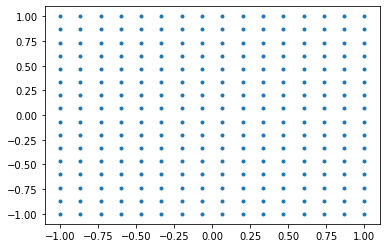

In [22]:
%matplotlib inline
# collect a grid of pixels
# pixels has shape (batch_size=1, res*res, 2)
res = gen.resolution_vol
n_points = res * res
n_steps = gen.n_ray_samples
_, pixels = im2scene.common.arange_pixels((res, res))
pixels = pixels
pixels[..., -1] *= -1. # why?
plt.scatter(*pixels[0].T, marker=".")
pixels = pixels.to(device)
res, n_points, n_steps

In [28]:
# get the camera and world matrix
range_u, range_v, range_radius = gen.range_u, gen.range_v, gen.range_radius
print(range_u, range_v, range_radius)

is_random = False
if is_random:
    world_mat = im2scene.camera.get_random_pose(range_u, range_v, range_radius, 1).to(device)
else:
    world_mat = im2scene.camera.get_middle_pose(range_u, range_v, range_radius, 1).to(device)
fov = 30
camera_mat = im2scene.camera.get_camera_mat(fov=fov).to(device)
camera_mat, world_mat

(0, 0) [0.066987, 0.283058] [7.0, 8.0]


(tensor([[[0.2679, 0.0000, 0.0000, -0.0000],
          [0.0000, 0.2679, 0.0000, -0.0000],
          [0.0000, 0.0000, 1.0000, -0.0000],
          [0.0000, 0.0000, 0.0000, 1.0000]]], device='cuda:0'),
 tensor([[[ 0.0000, -0.6500,  0.7600,  5.6998],
          [ 1.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.7600,  0.6500,  4.8747],
          [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0'))

<IPython.core.display.Javascript object>


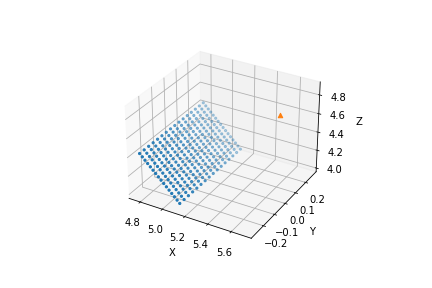

(torch.Size([1, 256, 3]),
 torch.Size([1, 256, 3]),
 tensor(7.5000, device='cuda:0'))

In [29]:
%matplotlib notebook
# project the grid of pixels to the world
# pixels_world has shape (batch_size=1, res*res, 3)
pixels_world = im2scene.common.image_points_to_world(pixels, camera_mat, world_mat)

# get the origin of the camera in world space
# camera_world has shape (batch_size=1, res*res, 3)
camera_world = im2scene.common.origin_to_world(n_points, camera_mat=camera_mat, world_mat=world_mat)

fig = plt.figure()#figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
pixels_world.shape, camera_world.shape, torch.norm(camera_world[0,0])

<IPython.core.display.Javascript object>


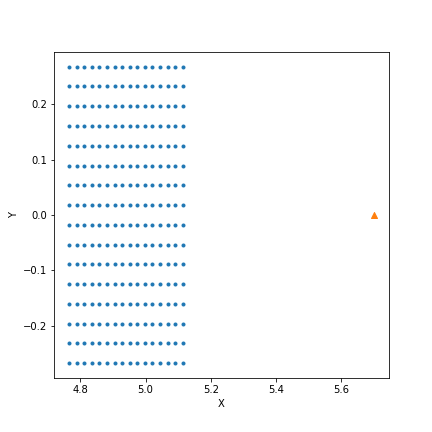

Text(0, 0.5, 'Y')

In [30]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*pixels_world.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0, :2].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')

In [31]:
# compute step sizes
depth_range = gen.depth_range
depth_range = [1.0, 11.0]
di = depth_range[0] + \
        torch.linspace(0., 1., steps=n_steps).reshape(1, 1, -1) * (
            depth_range[1] - depth_range[0])
# di has shape (batch_size=1, res*res, n_ray_samples)
di = di.repeat(1, n_points, 1).to(device)
di.shape, depth_range

(torch.Size([1, 256, 64]), [1.0, 11.0])

<IPython.core.display.Javascript object>


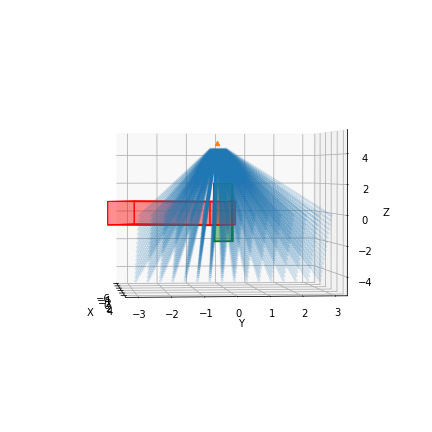

(torch.Size([1, 16384, 3]), torch.Size([1, 16384, 3]))

In [51]:
# get evaluation points
# this visualization is accurate with the red box only because it assumes no scaling

%matplotlib notebook
# p_i, r_i has shape (batch_size=1, ?, 3)
p_i, r_i = gen.get_evaluation_points(
        pixels_world, camera_world, di, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i.cpu()[0].T, marker=".", alpha=0.1)
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")

Z, verts = BB3D_about_origin(0.3, 0.3, 2)(x=-2.0, y=0, yaw=0)
# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
ax.add_collection3d(Poly3DCollection(verts, 
    facecolors='g', linewidths=1, edgecolors='g', alpha=.25))

Z, verts = make_car_BB3D_about_origin(x=0.0, y=2.0, yaw=(5/6)*np.pi)
# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
ax.add_collection3d(Poly3DCollection(verts, 
    facecolors='r', linewidths=1, edgecolors='r', alpha=.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, r_i.shape

<IPython.core.display.Javascript object>


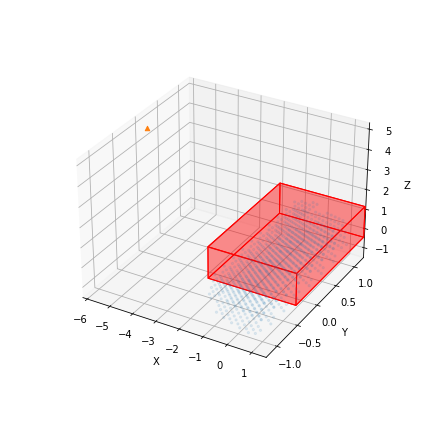

(torch.Size([1, 16384, 3]), torch.Size([1, 16384]), torch.Size([974, 3]))

In [44]:
%matplotlib notebook
# what does the "mask out values outside" lines do?
# after masking, there are 1588 / 16384 points with non-zero sigma,
# assuming no scaling 
# this code is run after the decoder.

padd = 0.1
mask_box = torch.all(
    p_i <= 1. + padd, dim=-1) & torch.all(
        p_i >= -1. - padd, dim=-1)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(*p_i[mask_box].cpu().T, marker=".", alpha=0.1)
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")

Z, verts = make_car_BB3D_about_origin(x=0.5, y=0.5, yaw=np.pi/2)
# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
ax.add_collection3d(Poly3DCollection(verts, 
 facecolors='r', linewidths=1, edgecolors='r', alpha=.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
p_i.shape, mask_box.shape, p_i[mask_box].shape

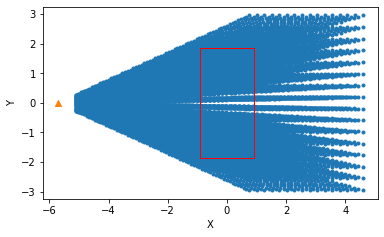

In [45]:
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(*p_i.cpu()[0, :, :2].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0, :2].T, marker="^")

# Audi A2 has dimensions (3.70 m, 1.79 m, 1.55 m)

vertices = make_car_BB2D_about_origin(x=0., y=0., yaw=np.pi/2)
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect("equal")

<IPython.core.display.Javascript object>


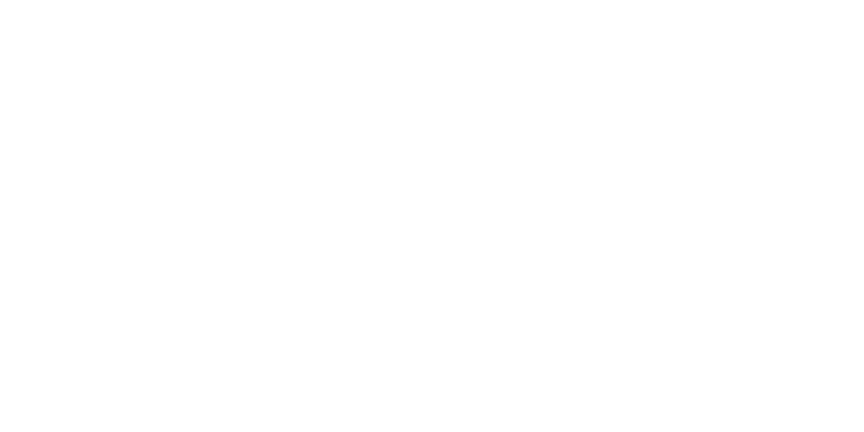

(torch.Size([1, 256, 3]), torch.Size([1, 256, 3]))

In [845]:
# transform_points_to_box() inside get_evaluation_points()
# transform before and after?
%matplotlib notebook

pixels_world_i = gen.transform_points_to_box(
        pixels_world, transformations, 0)
camera_world_i = gen.transform_points_to_box(
        camera_world, transformations, 0)

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(*pixels_world.cpu()[0].T, marker=".")
ax.scatter(*camera_world.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("coords before transformation")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*pixels_world_i.cpu()[0].T, marker=".")
ax.scatter(*camera_world_i.cpu()[0, 0].T, marker="^")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("coords after transformation")

pixels_world.shape, camera_world.shape

downscale_p_by 4.0
positional_encoding normal
n_freq_posenc 10
p_transformed has shape torch.Size([1, 16384, 60])


<IPython.core.display.Javascript object>


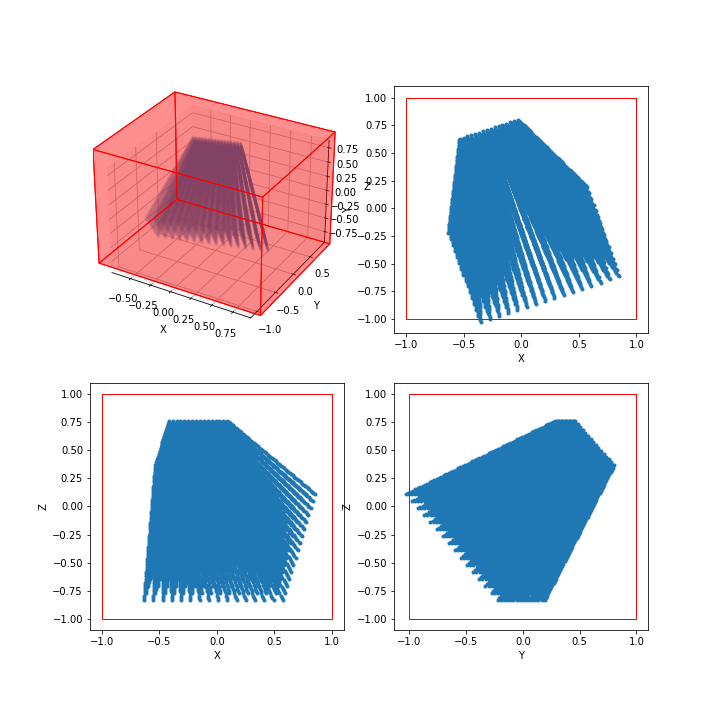

n_freq_posenc_views 4


In [846]:
%matplotlib notebook
z_shape_obj, z_app_obj, z_shape_bg, z_app_bg = latent_codes
z_shape_i, z_app_i = z_shape_obj[:, 0], z_app_obj[:, 0]

# the internals of gen.decoder(p_i, r_i, z_shape_i, z_app_i)
p_in, ray_d, z_shape, z_app = p_i, r_i, z_shape_i, z_app_i

# the internals of gen.decoder.transform_points() on p_in before doing gen.decoder.fc_in()
print("downscale_p_by", gen.decoder.downscale_p_by)
print("positional_encoding", gen.decoder.positional_encoding)
print("n_freq_posenc", gen.decoder.n_freq_posenc)

p = p_in
p = p /  gen.decoder.downscale_p_by
L = gen.decoder.n_freq_posenc
p_transformed = torch.cat([torch.cat(
    [torch.sin((2 ** i) * np.pi * p),
     torch.cos((2 ** i) * np.pi * p)],
    dim=-1) for i in range(L)], dim=-1)
print("p_transformed has shape", p_transformed.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(*p.cpu()[0].T, marker=".", alpha=0.1)

Z, verts = BB3D_about_origin(1., 1., 1.)()
# ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
ax.add_collection3d(Poly3DCollection(verts, 
    facecolors='r', linewidths=1, edgecolors='r', alpha=.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax = fig.add_subplot(222)
ax.scatter(*p.cpu()[0, :, :2].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Y')

ax = fig.add_subplot(223)
ax.scatter(*p.cpu()[0, :, [0, 2]].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('X')
ax.set_ylabel('Z')

ax = fig.add_subplot(224)
ax.scatter(*p.cpu()[0, :, 1:].T, marker=".")
vertices = BB2D_about_origin(1., 1.)()
patch = patches.Polygon(vertices, fill=False, color='r')
ax.add_patch(patch)
ax.set_xlabel('Y')
ax.set_ylabel('Z')

# gen.decoder.transform_points() claims to normalize points to [-1, 1]

# scale_range_min: [0.2, 0.16, 0.16]
# scale_range_max: [0.25, 0.2, 0.2]

print("n_freq_posenc_views", gen.decoder.n_freq_posenc_views)